In [10]:
import cupy as cp
from cupyx.scipy import fftpack
import numpy as np
import cv2
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim
from matplotlib import pyplot as plt
from cupyx.scipy.signal import fftconvolve


In [ ]:
def gaussian_filter_gpu(size, sigma):
    x, y = cp.meshgrid(cp.linspace(-1, 1, size), cp.linspace(-1, 1, size))
    d = cp.sqrt(x*x + y*y)
    g = cp.exp(-(d**2 / (2.0 * sigma**2)))
    return g / g.sum()

In [ ]:
def apply_kernel_gpu(image, kernel):
    # Use fftconvolve for convolution
    result = fftconvolve(image, kernel, mode='same')
    return result

In [13]:
import cupy as cp
from cupyx.scipy.fft import fft2, ifft2, fftshift

def wiener_deconvolution(input_image: cp.ndarray, target_image: cp.ndarray, noise_level: float = 0.1, kernel_size: int = 15) -> cp.ndarray:
    """
    Perform Wiener deconvolution to compute the deblurring kernel.

    Parameters:
    - input_image: cp.ndarray - The input (blurry) image.
    - target_image: cp.ndarray - The target (sharp) image.
    - noise_level: float - The noise level for regularization (default is 0.1).
    - kernel_size: int - The size of the deblurring kernel (default is 15).

    Returns:
    - cp.ndarray - The computed deblurring kernel.
    """
    # Compute FFT of input and target images
    input_fft = fft2(input_image)
    target_fft = fft2(target_image)
    
    # Estimate the filter in frequency domain
    filter_fft = cp.conj(input_fft) * target_fft / (cp.abs(input_fft)**2 + noise_level**2)
    
    # Convert filter back to spatial domain
    kernel = cp.real(ifft2(filter_fft))
    
    # Normalize and truncate the kernel
    kernel = kernel / cp.sum(kernel)
    kernel = fftshift(kernel)
    center = kernel.shape[0] // 2
    kernel = kernel[center - kernel_size // 2:center + kernel_size // 2 + 1,
                    center - kernel_size // 2:center + kernel_size // 2 + 1]
    
    return kernel


In [ ]:
# Load images
input_image = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE)
target_image = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE)

# Ensure both images have the same size
min_shape = np.minimum(input_image.shape, target_image.shape)
input_image = input_image[:min_shape[0], :min_shape[1]]
target_image = target_image[:min_shape[0], :min_shape[1]]

# Convert images to float and normalize to [0, 1]
input_image = cp.asarray(input_image.astype(np.float32) / 255.0)
target_image = cp.asarray(target_image.astype(np.float32) / 255.0)

def objective_function(params):
    sigma, kernel_size = params
    kernel_size = int(kernel_size)  # Ensure kernel_size is an integer
    
    hi = gaussian_filter_gpu(kernel_size, sigma)
    
    filtered_image = apply_kernel_gpu(input_image, hi)

    wiener_deconvoluted = wiener_deconvolution(input_image=input_image, )
    
    # Calculate SSIM (on CPU as skimage doesn't support GPU)
    ssim_value = ssim(cp.asnumpy(filtered_image), cp.asnumpy(target_image), 
                      data_range=1.0,
                      gaussian_weights=True,
                      sigma=1.5,
                      use_sample_covariance=False)
    
    # We want to maximize SSIM, so we return negative SSIM for minimization
    return -ssim_value

# Initial guess for parameters
initial_guess = [0.5, 100]

# Bounds for parameters (sigma should be positive, kernel_size between 3 and 200)
bounds = [(0.01, 10), (3, 200)]

# Optimize
result = minimize(objective_function, 
                  initial_guess, 
                  method='L-BFGS-B', 
                  bounds=bounds,
                  options={
                      'maxiter': 100
                  })

# Get optimized parameters
sigma_opt, kernel_size_opt = result.x

print(f"Optimized parameters: sigma={sigma_opt}, kernel_size={int(kernel_size_opt)}")
print(f"Best SSIM: {-result.fun}")

# Apply optimized filter for visualization
hi_opt = gaussian_filter_gpu(int(kernel_size_opt), sigma_opt)
filtered_image_opt = apply_kernel_gpu(input_image, hi_opt)

# Plot results (convert back to CPU for matplotlib)
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(cp.asnumpy(input_image), cmap='gray')
plt.title('Input Image'), plt.axis('off')
plt.subplot(132), plt.imshow(cp.asnumpy(filtered_image_opt), cmap='gray')
plt.title('Optimized Filtered Image'), plt.axis('off')
plt.subplot(133), plt.imshow(cp.asnumpy(target_image), cmap='gray')
plt.title('Target Image'), plt.axis('off')
plt.tight_layout()
plt.show()


In [4]:
ssim(cp.asnumpy(input_image), cp.asnumpy(target_image), 
                      data_range=1.0,
                      gaussian_weights=True,
                      sigma=1.5,
                      use_sample_covariance=False)

0.23887918917439016

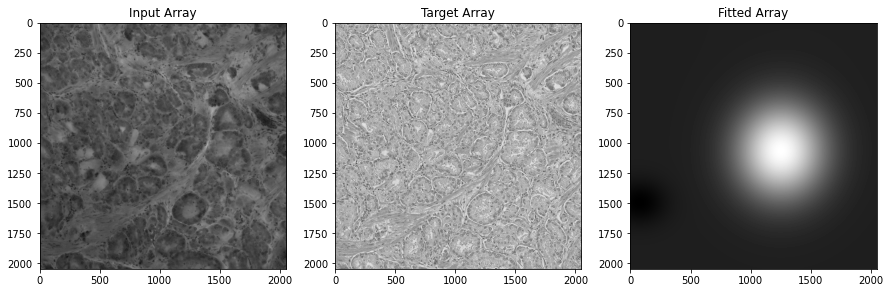

Final SSIM: 0.0388225533105897


In [20]:
import cupy as cp
import numpy as np
import cv2
from scipy.optimize import minimize
from skimage.metrics import structural_similarity as ssim

def gaussian_2d(x, y, amplitude, x0, y0, sigma_x, sigma_y):
    return amplitude * cp.exp(-(((x - x0) / sigma_x)**2 + ((y - y0) / sigma_y)**2) / 2)

def gaussian_sum(params, x, y):
    result = cp.zeros_like(x, dtype=cp.float64)
    for i in range(0, len(params), 5):
        amplitude, x0, y0, sigma_x, sigma_y = params[i:i+5]
        result += gaussian_2d(x, y, amplitude, x0, y0, sigma_x, sigma_y)
    return result

def objective_ssim(params, x, y, target):
    predicted = gaussian_sum(params, x, y)
    # Convert CuPy arrays to NumPy for SSIM calculation
    predicted_np = cp.asnumpy(predicted)
    target_np = cp.asnumpy(target)
    return -ssim(predicted_np, target_np, data_range=1.0)

# Example usage
input_array = cp.asarray(cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0)
target_array = cp.asarray(cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0)

# Create x and y coordinate arrays
y, x = cp.indices(input_array.shape, dtype=cp.float64)

# Initial guess for parameters (example with 3 Gaussians)
initial_params = []
for _ in range(3):
    amplitude = cp.random.rand()
    x0 = cp.random.randint(0, input_array.shape[1])
    y0 = cp.random.randint(0, input_array.shape[0])
    sigma_x = cp.random.rand() * 50
    sigma_y = cp.random.rand() * 50
    initial_params.extend([amplitude, x0, y0, sigma_x, sigma_y])

initial_params = cp.array(initial_params, dtype=cp.float64)

# Optimize
result = minimize(objective_ssim, cp.asnumpy(initial_params), args=(x, y, target_array), method='L-BFGS-B')

# Generate the fitted array
fitted_array = gaussian_sum(cp.asarray(result.x), x, y)

# Display results
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(cp.asnumpy(input_array), cmap='gray')
plt.title('Input Array')
plt.subplot(132)
plt.imshow(cp.asnumpy(target_array), cmap='gray')
plt.title('Target Array')
plt.subplot(133)
plt.imshow(cp.asnumpy(fitted_array), cmap='gray')
plt.title('Fitted Array')
plt.show()

# Print final SSIM
final_ssim = ssim(cp.asnumpy(fitted_array), cp.asnumpy(target_array), data_range=1.0)
print(f"Final SSIM: {final_ssim}")

In [25]:
import numpy as np
import cupy as cp
import cupyx.scipy.signal as cps
import cv2
from skimage.metrics import structural_similarity as ssim

def gaussian_filter(size, sigma):
    x, y = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    d = np.sqrt(x*x + y*y)
    g = np.exp(-(d**2 / (2.0 * sigma**2)))
    return g / g.sum()

def convolve_arrays(array1, array2, mode='same'):
    cupy_array1 = cp.asarray(array1)
    cupy_array2 = cp.asarray(array2)
    result_cupy = cps.fftconvolve(cupy_array1, cupy_array2, mode=mode)
    return cp.asnumpy(result_cupy)

input_array = cv2.imread('Prostate.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0
target_array = cv2.imread('good.jpg', cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255.0

le_score = 0
le_optimal_kernel = 0
le_optimal_sigma = 0

for sigma in np.arange(0.1, 10, 0.1):  # Increased step and starting value for faster execution
    for kernel_size in range(3, 51, 2):  # Odd kernel sizes from 3 to 49
        gaussian = gaussian_filter(kernel_size, sigma)
        le_image = convolve_arrays(input_array, gaussian)
        
        # Ensure le_image and target_array have the same dimensions
        min_shape = np.minimum(le_image.shape, target_array.shape)
        le_image_crop = le_image[:min_shape[0], :min_shape[1]]
        target_array_crop = target_array[:min_shape[0], :min_shape[1]]
        
        ssim_value = ssim(le_image_crop, target_array_crop, data_range=1.0)
        if ssim_value > le_score:
            le_score = ssim_value
            le_optimal_kernel = kernel_size
            le_optimal_sigma = sigma
            
print(f"Optimal sigma: {le_optimal_sigma}, Optimal kernel size: {le_optimal_kernel}")
print(f"Best SSIM score: {le_score}")